# Environment

In [1]:
import gym
import numpy as np

import os

from stable_baselines3.common.monitor import Monitor

In [2]:
name = "BreakoutNoFrameskip-v4"
env = gym.make(name)
spec = gym.spec(name)

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}")

Action Space: Discrete(4)
Observation Space: Box(210, 160, 3)
Max Episode Steps: 400000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None


# Model

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
tf.get_logger().setLevel('INFO')

def build_model(input_shape, output_shape):
    x = Input(shape=input_shape)

    conv1 = Conv2D(32, 8, strides=4, activation="relu")(x)
    conv2 = Conv2D(64, 4, strides=2, activation="relu")(conv1)
    conv3 = Conv2D(64, 3, strides=1, activation="relu")(conv2)
    flat = Flatten()(conv3)
    dense = Dense(512, activation="relu")(flat)

    y = Dense(output_shape, activation="linear")(dense)

    model = Model(inputs=x, outputs=y)
    return model

optimizer = Adam(learning_rate=0.00025, clipnorm=1.0)
loss_fn = tf.keras.losses.Huber()

2021-07-24 11:26:20.753392: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Replay Memory

In [4]:
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):

    def __init__(self, capacity, batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size = batch_size

    def push(self, *args):
        """ Save a transition """
        self.memory.append(Transition(*args))

    def sample(self):
        """ Get a random element from the memory buffer """
        return random.sample(self.memory, self.batch_size)

    def __len__(self):
        return len(self.memory)

capacity = 150000
batch_size = 32
memory = ReplayMemory(capacity, batch_size)

# Wrappers

In [5]:
from baselines.common import atari_wrappers

def wrap_env(name):
    env = gym.make(name)
    env = atari_wrappers.NoopResetEnv(env, noop_max=30)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.TimeLimit(env, max_episode_steps=10000)
    env = atari_wrappers.FireResetEnv(env)
    env = atari_wrappers.WarpFrame(env)
    env = atari_wrappers.ClipRewardEnv(env)
    env = atari_wrappers.FrameStack(env, 4)
    return env

# Deep Q-Learning

In [6]:
import datetime

class DeepQLearning :
    def __init__(self, env, memory, gamma=0.99, epsilon=1.0):
        """
        :param env: OpenAI RL environment to solve
        :param memory: Replay Buffer memory
        :param gamma: Decay factor
        :param epsilon: Exploration term
        """
        self.env = env
        self.dqn = build_model(env.observation_space.shape, env.action_space.n)
        self.dqn_target = build_model(env.observation_space.shape, env.action_space.n)
        self.dqn_target.set_weights(self.dqn.get_weights())
        self.memory = memory
        self.gamma = gamma
        self.epsilon = epsilon
        self.loss_hist = []


    def _bellman_equation(self):
        """ Update the Deep Q Network model with discounted reward """
        # Sample batch
        transitions = self.memory.sample()
        state, action, next_state, reward, done = Transition(*zip(*transitions))

        # Q value = reward + discount factor * expected future reward
        future_q_values = self.dqn_target(np.stack(next_state) / 255)
        updated_q_values = reward + self.gamma * (tf.reduce_max(future_q_values, axis=1)) * (1 - np.array(done))
        
        # Mask all the action not taken
        masks = tf.one_hot(action, env.action_space.n)

        with tf.GradientTape() as tape:
            q_values = self.dqn(np.stack(state) / 255)
            # Select the predicted q-values of action taken
            q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)

            loss = loss_fn(updated_q_values, q_action)

        self.losses.append(loss)

        # Backpropagation
        grads = tape.gradient(loss, self.dqn.trainable_variables)
        optimizer.apply_gradients(zip(grads, self.dqn.trainable_variables))

    def _epsilon_decay(self, exploration_steps):
        """
        Decay the exploration factor in training.
        :param exploration_steps: Number of steps until stoping random exploration 
        :return: new exploration factor
        """
        if self.epsilon > 0.1:
            epsilon_decay = (1 - 0.1) / exploration_steps
            return max(self.epsilon - epsilon_decay, 0.1)
        
        return self.epsilon


    def predict(self, obs):
        """
        Q-Learning table lookup for decision making.
        :param obs: Current observation of the agent
        :return: Action the agent will make & the associated q-values.
        """
        if np.random.uniform(0, 1) < self.epsilon:
            # Select a random action at random occurrences
            return self.env.action_space.sample()

        # Select optimal action
        qvals = self.dqn(np.array([obs]) / 255, training=False)[0]
        return np.argmax(qvals)

    def learn(self, total_steps, exploration_steps, verbose=1):
        """ Deep Q-Learning updating through game-playing """
        timestamp = datetime.datetime.now().strftime("%H:%M:%S")
        print(f'{timestamp} | Starting training.')

        scores = deque([], maxlen=100)
        self.losses = []
        episode = 0
        steps = 0

        while True:
            # Reset variables for new game
            state = self.env.reset()
            game_over = False
            episode += 1
            episode_reward = 0
            lives = 5
            next_action = 0

            while not game_over :
                # Predict new decision
                action = self.predict(state)

                # Simulate decision
                next_state, reward, game_over, info = self.env.step(action)
                done = game_over

                # Un-incentivize loosing lives
                if lives > info['ale.lives']:
                    lives = info['ale.lives']
                    reward = -1
                    done = True
                    next_action = 1

                # Save step
                self.memory.push(
                    np.array(state),
                    action,
                    np.array(next_state),
                    reward,
                    done)

                # Decay exploration
                self.epsilon = self._epsilon_decay(exploration_steps)

                if self.memory.__len__() > 64 and not steps % 4:
                    # Policy Gradient
                    self._bellman_equation()

                # Track the run
                state = next_state
                episode_reward += reward
                steps += 1

                if not steps % 10000:
                    # Update the the target network
                    self.dqn_target.set_weights(self.dqn.get_weights())

                if not steps % 50000:
                    # Log details
                    timestamp = datetime.datetime.now().strftime("%H:%M:%S")
                    print(f'{timestamp} | Epoch {int(steps/50000)} - Episode {episode} - Running reward {np.mean(scores):0.2f} - Epsilon {self.epsilon:0.4f} - Loss {np.mean(self.losses):0.4f}.')
                    
                    self.loss_hist.append(np.mean(self.losses))
                    self.losses = []

                    # Save model
                    self.dqn.save_weights(log_dir + f"weights/Epoch-{int(steps/50000)}.h5")

            scores.append(episode_reward)

            if steps > total_steps:
                env.close()
                np.save(log_dir + 'loss', np.vstack(
                    (np.arange(len(self.loss_hist)), self.loss_hist)).T)
                return

# Training

In [7]:
# Create log dir
log_dir = f"logs/{name}/"
os.makedirs(log_dir + 'weights', exist_ok=True)
# Create and wrap the environment
env = wrap_env(name)
# Logs will be saved in log_dir/
env = Monitor(env, log_dir)
env.seed(42)
np.random.seed(42)

model = DeepQLearning(env, memory)

max_steps = 5000000
exploration_steps = 1000000
model.learn(max_steps, exploration_steps)

2021-07-23 19:02:30.389950: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-23 19:02:30.423390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-23 19:02:30.423904: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 computeCapability: 6.1
coreClock: 1.6705GHz coreCount: 10 deviceMemorySize: 5.94GiB deviceMemoryBandwidth: 178.99GiB/s
2021-07-23 19:02:30.423961: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-23 19:02:30.428104: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-23 19:02:30.428184: I tensorflow/stream_executor/pl

19:02:31 | Starting training.


2021-07-23 19:02:31.328121: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-23 19:02:31.771938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8202
2021-07-23 19:02:32.214695: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-23 19:02:32.556895: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


19:08:29 | Epoch 1 - Episode 262 - Running reward -3.66 - Epsilon 0.9550 - Loss 0.0096.
19:14:35 | Epoch 2 - Episode 536 - Running reward -3.75 - Epsilon 0.9100 - Loss 0.0068.
19:21:02 | Epoch 3 - Episode 803 - Running reward -3.48 - Epsilon 0.8650 - Loss 0.0064.
19:27:26 | Epoch 4 - Episode 1057 - Running reward -3.03 - Epsilon 0.8200 - Loss 0.0075.
19:34:11 | Epoch 5 - Episode 1267 - Running reward -2.04 - Epsilon 0.7750 - Loss 0.0086.
19:40:59 | Epoch 6 - Episode 1442 - Running reward -1.16 - Epsilon 0.7300 - Loss 0.0104.
19:47:51 | Epoch 7 - Episode 1620 - Running reward -1.00 - Epsilon 0.6850 - Loss 0.0114.
19:54:50 | Epoch 8 - Episode 1785 - Running reward -0.22 - Epsilon 0.6400 - Loss 0.0136.
20:01:58 | Epoch 9 - Episode 1939 - Running reward 0.40 - Epsilon 0.5950 - Loss 0.0148.
20:09:09 | Epoch 10 - Episode 2081 - Running reward 0.46 - Epsilon 0.5500 - Loss 0.0130.
20:16:24 | Epoch 11 - Episode 2210 - Running reward 1.76 - Epsilon 0.5050 - Loss 0.0119.
20:23:37 | Epoch 12 - Epi

# Evaluation

In [8]:
# Log
import csv  

header = ['Epoch', 'Reward', 'Q']
with open(log_dir + 'metrics.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(header)

def logger(epoch, reward, q):
    data = [epoch, reward, q]

    with open(log_dir + 'metrics.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow(data)

In [10]:
def evaluate(model, epoch, max_steps=10000, verbose=1):
    """
    Evaluate a RL agent
    :param model: the RL Agent
    :param max_steps: number of frames to evaluate over
    :return: Mean reward for the last num_episodes
    """
    all_episode_rewards = []
    qvals = []
    steps = 0 
    env = wrap_env_eval(name)

    # Repeat untill max_steps are played
    while True:
        episode_rewards = []
        done = False
        obs = env.reset()

        while not done:
            # Action selection
            if model is None:
                qval = 0
                action = env.action_space.sample()
            else:
                qval = model.dqn(np.array([obs]) / 255)[0]
                action = np.argmax(qval)

            # Simulation
            qvals.append(np.max(qval))
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

            # Wrap up
            steps += 1
            if steps > max_steps:
                env.close()
                all_episode_rewards.append(sum(episode_rewards))
                mean_episode_reward = np.mean(all_episode_rewards)
                mean_q_value = np.mean(qvals)

                if verbose:
                    print(f"Epoch: {epoch} - Mean reward: {mean_episode_reward:0.4f} Mean Q-value: {mean_q_value:0.4f}")

                return mean_episode_reward, mean_q_value

        all_episode_rewards.append(sum(episode_rewards))

In [11]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

video_folder = log_dir + 'video'

def save_episode(model, comment):
    video_length = 5000

    env = wrap_env_eval(name)
    env = DummyVecEnv([lambda: env])
    # Record the video
    env = VecVideoRecorder(env, video_folder,
                        record_video_trigger=lambda x: x == 0,
                        video_length=video_length,
                        name_prefix="DQL-{}-{}".format(name, comment))

    # Simulate game
    obs = env.reset()

    for _ in range(video_length + 1):
        if model is not None:
            action = np.argmax(model.dqn(np.array(obs) / 255)[0])
        else:
            action = env.action_space.sample()

        obs, reward, done, info = env.step([action])

        if done:
            break

    env.close()

In [12]:
def wrap_env_eval(name):
    env = gym.make(name)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.FireResetEnv(env)
    env = atari_wrappers.WarpFrame(env)
    env = atari_wrappers.FrameStack(env, 4)
    return env

In [17]:
# Baseline
save_episode(None, 'RandomAgent')
eval_reward, eval_qval = evaluate(None, 0)
logger(0, eval_reward, eval_qval)

for epoch in range(int(max_steps / 50000)):
    model.dqn.load_weights(log_dir + f'/weights/Epoch-{epoch + 1}.h5')
    eval_reward, eval_qval = evaluate(model, epoch + 1, max_steps=10000, verbose=0)
    logger(epoch + 1, eval_reward, eval_qval)
    save_episode(model, f'Epoch-{epoch + 1}')

Epoch: 0 - Mean reward: 0.9500 Mean Q-value: 0.0000
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-26-step-0-to-step-5000.mp4
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-30-step-0-to-step-5000.mp4
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-31-step-0-to-step-5000.mp4
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-42-step-0-to-step-5000.mp4
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-44-step-0-to-step-5000.mp4
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-48-step-0-to-step-5000.mp4
Saving video to /home/pf/Documents/rl/logs/BreakoutNoFrameskip-v4/video/DQL-BreakoutNoFrameskip-v4-Epoch-53-step-0-to-step-5000.mp4
Saving video to /home/pf

## Plots

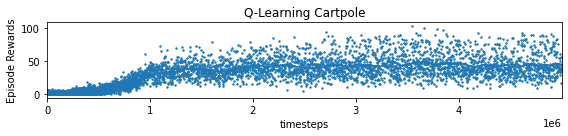

In [29]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results([log_dir], max_steps, results_plotter.X_TIMESTEPS, "Deep Q-Learning Breakout")

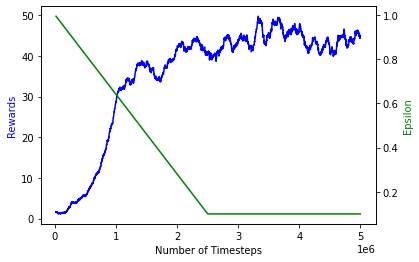

In [33]:
from stable_baselines3.common.results_plotter import load_results, ts2xy

def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y1 = ts2xy(load_results(log_folder), 'timesteps')
    y1 = moving_average(y1, window=100)
    # Truncate x
    x = x[len(x) - len(y1):]

    # Exploration epsilon values
    exploration_steps = max_steps / 2
    epsilon_decay = (1 - 0.1) / exploration_steps
    y2 = np.array([max(1 - epsilon_decay * time, 0.1) for time in range(int(max_steps))])[x[x < max_steps]]
    
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(x, y1, 'b-')
    ax2.plot(x[x < max_steps], y2, 'g-')

    ax1.set_xlabel('Number of Timesteps')
    ax1.set_ylabel('Rewards', color='b')
    ax2.set_ylabel('Epsilon', color='g')

    plt.show()

plot_results(log_dir)

## Model interpretability

In [19]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_layer_output(model, idx, sample):
    assert idx < len(model.layers)
    assert idx > -2

    try:
        data_flow = K.function([model.layers[0].input],
                            [model.layers[idx].output])
        return data_flow(sample)
    except:
        print("Cannot get the layer")
        return None

def agent_plots(frame, dqn, obs, qval, rewards):
    # Inspired by: https://github.com/cookie2004/GRLA/blob/ee0105f44de31959496dfe930d60d5fd4530597d/210418_Model_eval.ipynb
    fig = plt.figure(figsize=(25, 20))
    fig.patch.set_facecolor('black')
    gs = GridSpec(nrows=6, ncols=4)

    # Raw observation
    ax0 = fig.add_subplot(gs[0:4, 0:2]) 
    ax0.axis('off')
    ax0.imshow(frame)
    ax0.set_title('Raw observation', color='white', fontsize=25)

    # Processed frame
    ax1 = fig.add_subplot(gs[0, 2:])
    ax1.set_xlim(0, 84*4)
    ax1.axis('off')
    for i in range(4):
        ax1.imshow(obs[0, :, :, i], origin='upper', extent=[i*84, i*84+84, 0, 84])
        ax1.plot([i*84, i*84], [0, 84], color='black')
    ax1.set_title('4 Temporal processed frames - 84x84', color='white', fontsize=25)

    # Model layers
    vfeat = get_layer_output(dqn, 1, np.array(obs) / 255)[0]
    ax2 = fig.add_subplot(gs[1, 2:])
    ax2.axis('off')
    for i in range(32):
        ax2.imshow(vfeat[0, :, :, i], origin='upper', extent=[int(i%8)*20, int(i%8)*20+20, int(i/8)*20, int(i/8)*20+20])
        ax2.plot([int(i%8)*20, int(i%8)*20], [int(i/8)*20, int(i/8)*20+20], color='black')
    ax2.set_title('Conv2D layer - 20x20x32', color='white', fontsize=25)

    vfeat = get_layer_output(dqn, 2, np.array(obs) / 255)[0]
    ax3 = fig.add_subplot(gs[2, 2:])
    ax3.axis('off')
    for i in range(64):   
        ax3.imshow(vfeat[0, :, :, i], origin='upper', extent=[int(i%16)*9, int(i%16)*9+9, int(i/16)*9, int(i/16)*9+9])
        ax3.plot([int(i%16)*9, int(i%16)*9], [int(i/16)*9, int(i/16)*9+9], color='black')
    ax3.set_title('Conv2D layer - 9x9x64', color='white', fontsize=25)

    vfeat = get_layer_output(dqn, 3, np.array(obs) / 255)[0]
    ax4 = fig.add_subplot(gs[3, 2:])
    ax4.axis('off')
    for i in range(64):   
        ax4.imshow(vfeat[0, :, :, i], origin='upper', extent=[int(i%16)*7, int(i%16)*7+7, int(i/16)*7, int(i/16)*7+7])
        ax4.plot([int(i%16)*7, int(i%16)*7], [int(i/16)*7, int(i/16)*7+7], color='black')
    ax4.set_title('Conv2D layer - 7x7x64', color='white', fontsize=25)

    vfeat = get_layer_output(dqn, 4, np.array(obs) / 255)[0]
    ax5 = fig.add_subplot(gs[4, 2:])
    ax5.axis('off')
    ax5.imshow(np.reshape(vfeat[0], (32, 98)))
    ax5.set_title('Flatten layer - 1x3136', color='white', fontsize=25)

    vfeat = get_layer_output(dqn, 5, np.array(obs) / 255)[0]
    ax6 = fig.add_subplot(gs[5, 2:])
    ax6.axis('off')
    ax6.imshow(np.reshape(vfeat[0], (8, 64)))
    ax6.set_title('Dense layer - 1x512', color='white', fontsize=25)

    # Q value
    ax7 = fig.add_subplot(gs[4:, 0])
    ax7.bar(np.arange(4), qval, edgecolor='white', color='black', width=0.25, linewidth=2.0)
    ax7.set_ylabel('Q value', fontsize=25, color='white')
    ax7.set_xlabel('Action', fontsize=25, color='white')
    ax7.tick_params(axis='both', labelsize=25, color='white', labelcolor='white')
    ax7.set_facecolor('black')
    ax7.spines['bottom'].set_color('white')
    ax7.spines['top'].set_color('white')
    ax7.spines['left'].set_color('white')
    ax7.spines['right'].set_color('white')

    # Cumulative Reward
    ax8 = fig.add_subplot(gs[4:,1])
    ax8.plot(np.cumsum(rewards), color='white', linewidth=2.0)
    ax8.set_ylabel('Cumulative Reward', fontsize=25, color='white')
    ax8.set_xlabel('Step', fontsize=25, color='white')
    ax8.tick_params(axis='x', labelsize=25, color='white', labelcolor='white')
    ax8.tick_params(axis='y', which='both', labelleft=False)
    ax8.set_facecolor('black')
    ax8.spines['bottom'].set_color('white')
    ax8.spines['top'].set_color('white')
    ax8.spines['left'].set_color('white')
    ax8.spines['right'].set_color('white')
    
    canvas = FigureCanvas(fig)
    canvas.draw()  
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    return image

def agent_video(dqn):
    env = wrap_env_eval(name)
    env = DummyVecEnv([lambda: env])
    # Record the video
    env = VecVideoRecorder(env, video_folder,
                        record_video_trigger=lambda x: x == 0,
                        video_length=1000,
                        name_prefix="TrainedAgent")
    
    obs = env.reset()
    done = False
    rewards = []
    step = 0

    while not done:
        # Action selection
        qval = dqn(np.array(obs) / 255)[0]
        action = np.argmax(qval)

        # Simulation
        obs_next, reward, done, info = env.step([action])

        # Plot stuff
        ret = agent_plots(
            env.get_images()[0],
            dqn,
            np.array(obs),
            qval,
            rewards)
        plt.close()
        cv2.imwrite(video_folder + f'/frames/{step}.jpg', ret[:, :, [2, 1, 0]])

        rewards.append(reward[0])
        obs = obs_next
        step += 1
        if np.sum(rewards) >= 15 or info[0]['ale.lives'] < 4:
            break

    env.close()

agent_video(model.dqn)

In [20]:
# Save frames to a video
# ! cd $log_dir'video/frames'; ffmpeg -framerate 24 -i %d.jpg -c:v libx264 -pix_fmt yuv420p ../DQN-layers.mp4

In [27]:
from IPython.display import Video

Video(video_folder + f"/DQL-BreakoutNoFrameskip-v4-Epoch-100-step-0-to-step-5000.mp4")